In [253]:
import torch
from torch import nn
import pandas as pd
import numpy as np

!activate tensorflow_env


(tensorflow_env) C:\Users\andre\iCloudDrive\afstudeerproject\technical project>conda.bat activate tensorflow_env 


# Artificial Neural Network (ANN) for demand response (DR) pricing in the Energy Market

In [254]:
stdev = 2

# NL, SE1, ES
country = 'ES'


df = pd.read_csv(f'{country}_DA_price_v_actual_load_stdev_{stdev}.csv', index_col=0)
old_df = df.copy()
df = df.drop(df[df['DA Price'] <= 0].index)

train_len = int(len(df)*0.7)
train_df = df[:train_len]
train_df = train_df[['hour', 'day', 'month', 'DA Price', 'MW Load']]

test_df = df.copy()

In [255]:
test_df = test_df[:-(len(test_df)%24)]
test_df = test_df[['hour', 'day', 'month', 'DA Price', 'MW Load']]

In [256]:
x_test_arr = np.array([test_df[['hour', 'day', 'month','DA Price']]])
x_test = torch.tensor(x_test_arr).to(device='cpu')

x_test = x_test.reshape((-1, 24, 4))

y_test_arr = np.array([test_df[['MW Load']]])
y_test = torch.tensor(y_test_arr).to(device='cpu').flatten()

In [257]:
# decent distr - skewed too much left
# bad predictions
#PATH = 'results/pytorch_models/NL_test_100000epochs_0.005lr_0pm_0.5ps_0.1kl_5000bs_1.11hn_2stdev.pth'

# good distribution - needs to be spread more
# decent predictions
#PATH = 'results/pytorch_models/NL_test_50000epochs_0.005lr_0pm_0.5ps_0.1kl_5000bs_1.11hn_2stdev.pth'


# good distr
# decent predictions, mape = 0.17842524399395834
#PATH = 'results/pytorch_models/NL_test_50000epochs_0.001lr_0pm_0.1ps_0.1kl_5000bs_1.11hn_2stdev.pth'

# best yet
# good distr
# mape = 0.11222874263557618
# 0.5 dropout
PATH = 'results/pytorch_models/NL_test_50002epochs_0.001lr_0pm_0.1ps_0.1kl_5000bs_1.11hn_2stdev.pth'


# pretty decent
# one main peak in distribution
# mape = 0.18582326982692587
#PATH = 'results/pytorch_models/NL_test_50006epochs_0.005lr_0pm_0.1ps_0.5dropoutkl_2400bs_1.11hn_2stdev.pth'

# fairly good distibrution
# mape = 0. 11195788581997852
#path = 'results/pytorch_models/NL_test_20000epochs_0.0005lr_0pm_0.1ps_0.1dropoutkl_2400bs_1.11hn_2stdev.pth'

model = torch.load(PATH)
model.cpu()
model.eval()
print(model)

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (5): ReLU()
  (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (7): ReLU()
  (8): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (9): Dropout(p=0.5, inplace=True)
  (10): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (11): ReLU()
  (12): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=4, bias=True)
  (13): ReLU()
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=96, out_features=48, bias=True)
  (16): ReLU()
  (17): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=48, out_features=24, bia

In [258]:
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))

def MAPELoss_distr(output, target):
    return np.abs((target - output) / target)

def APELoss_distr(output, target):
    return np.abs(target - output)

In [259]:
y_pred = model(x_test).flatten()
mape_loss = MAPELoss(y_pred, y_test)


In [260]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [261]:
new_model = tf.keras.models.load_model('new/final/models_reference')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24, 4)             20        
                                                                 
 dense_1 (Dense)             (None, 24, 4)             20        
                                                                 
 dense_2 (Dense)             (None, 24, 4)             20        
                                                                 
 dense_3 (Dense)             (None, 24, 4)             20        
                                                                 
 dense_4 (Dense)             (None, 24, 4)             20        
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 48)                4

In [262]:
x_test = x_test.numpy()
y_pred_tf = new_model.predict(x_test)
y_pred_tf = y_pred_tf.flatten()
mape_loss_tf = MAPELoss(y_pred_tf, y_test)

### MAPE

In [263]:
print(f'Pytorch MAPE loss mean: {mape_loss}')
print(f'Tensorflow reference MAPE loss: {mape_loss_tf}')

Pytorch MAPE loss mean: 0.5333171266409634
Tensorflow reference MAPE loss: 0.5763361493124478


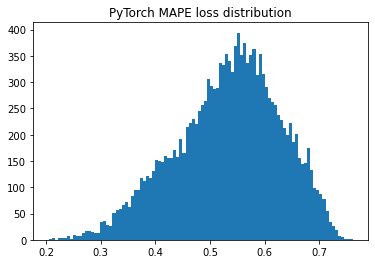

In [264]:
#print(MAPELoss_distr(y_pred, y_test))
torch_mape_distr = MAPELoss_distr(y_pred.detach().numpy(), y_test.detach().numpy())
plt.hist(torch_mape_distr, bins=100)
plt.title('PyTorch MAPE loss distribution')
plt.show()

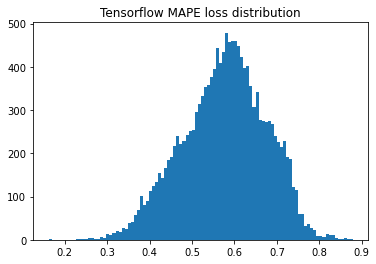

In [265]:
tf_mape_distr = MAPELoss_distr(y_pred_tf, y_test.detach().numpy())
plt.hist(tf_mape_distr, bins=100)
plt.title('Tensorflow MAPE loss distribution')
plt.show()

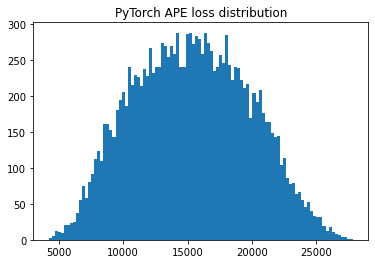

In [266]:
torch_ape_distr = APELoss_distr(y_pred.detach().numpy(), y_test.detach().numpy())
plt.hist(torch_ape_distr, bins=100)
plt.title('PyTorch APE loss distribution')
plt.show()

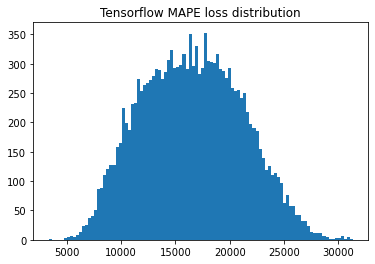

In [267]:
tf_ape_distr = APELoss_distr(y_pred_tf, y_test.detach().numpy())
plt.hist(tf_ape_distr, bins=100)
plt.title('Tensorflow MAPE loss distribution')
plt.show()

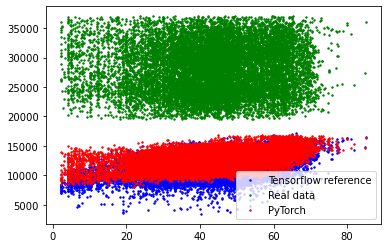

In [268]:
import matplotlib.pyplot as plt
plt.scatter(x_test[:,:,-1].flatten(), y_pred_tf, c='b', s=2, label='Tensorflow reference')
plt.scatter(x_test[:,:,-1].flatten(), y_test, c='g', s=2, label='Real data')
plt.scatter(x_test[:,:,-1].flatten(), y_pred.detach().numpy(), c='r', s=2, label='PyTorch')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Total MW Load per 24 hours histogram')

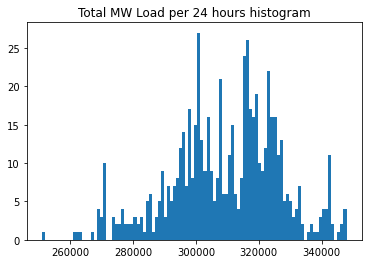

In [269]:
# PyTorch
N = 24


# average per 24 hours:
y_pred_arr = y_pred.detach().numpy()
y_pred_avg24 = np.sum(y_pred_arr.reshape(-1,24), axis=1)
plt.hist(y_pred_avg24, bins=100)
plt.title('Total MW Load per 24 hours histogram')

Text(0.5, 1.0, 'Total MW Load per 24 hours histogram Tensorflow pred')

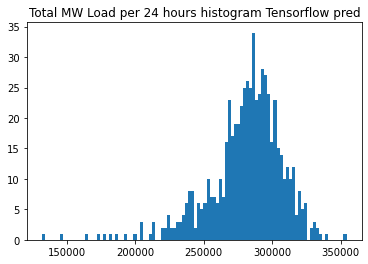

In [270]:
# Tensorflow

# average per 24 hours:
y_pred_tf_avg24 = np.sum(y_pred_tf.reshape(-1,24), axis=1)
plt.hist(y_pred_tf_avg24, bins=100)
plt.title('Total MW Load per 24 hours histogram Tensorflow pred')

(624,)


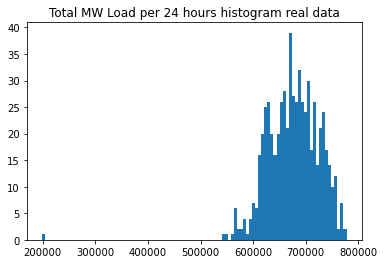

In [271]:
# real histogram
N = 24
plt.hist(old_df['MW Load'].groupby(old_df['MW Load'].index // N).sum(), bins=100)
print(old_df['MW Load'].groupby(old_df['MW Load'].index // N).sum().shape)
plt.title('Total MW Load per 24 hours histogram real data')
plt.show()